## imports

In [1]:
from jax import vmap
import jax
import jax.numpy as jnp
import jax.random as jr
import matplotlib.pyplot as plt
import numpy as np
import time
from equinox_module import training_MODEL, create_FNN, save_MODEL, load_FNN

jax.config.update("jax_platform_name", "cpu")


In [2]:
SEED = 777

key = jr.PRNGKey(SEED)
key, subkey_model, subkey_tr, subkey_tr_test, subkey_tt = jr.split(key, num=5)

Metal device set to: Apple M1 Pro

systemMemory: 16.00 GB
maxCacheSize: 5.33 GB



W0000 00:00:1763320498.370477 20614665 mps_client.cc:510] WARNING: JAX Apple GPU support is experimental and not all JAX functionality is correctly supported!
I0000 00:00:1763320498.393954 20614665 service.cc:145] XLA service 0x134460c10 initialized for platform METAL (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1763320498.393985 20614665 service.cc:153]   StreamExecutor device (0): Metal, <undefined>
I0000 00:00:1763320498.396051 20614665 mps_client.cc:406] Using Simple allocator.
I0000 00:00:1763320498.396065 20614665 mps_client.cc:384] XLA backend will use up to 11452858368 bytes on device 0 for SimpleAllocator.


## generate data

In [3]:
def rollout_fn(f, n, dt, include_init: bool = False):
    def scan_fn(u, _):
        # RK 45 Numerical Integrator
        k1 = dt * f(u)
        k2 = dt * f(u + 0.5*k1)
        k3 = dt * f(u + 0.5*k2)
        k4 = dt * f(u + k3)
        u_next = u + (k1 + 2*k2 + 2*k3 + k4) / 6
        return u_next, u_next

    def rollout_fn(u_0):
        _, trj = jax.lax.scan(scan_fn, u_0, None, length=n)

        if include_init:
            return jnp.concatenate([jnp.expand_dims(u_0, axis=0), trj], axis=0)

        return trj

    return rollout_fn

In [4]:
a, b, tau, I = 0.7, 0.8, 12.5, 0.5 # params

# define fitzhugh-nagumo ode
def f(x):
    v,w = x[0], x[1]
    return jnp.array([
        v - v**3 / 3 - w + I,
        (1/tau) * (v + a - b * w)
    ])

### training trajectories

In [5]:
dt = 0.01
T_final = 0.2
NUM_TRAJS = 30
NUM_STEPS = T_final // dt

initial_states = jr.uniform(subkey_tr, (NUM_TRAJS, 2), minval=jnp.array([-2, -2]), maxval=jnp.array([2,2])) # uniform [-2,2]^2

RK45_integrator = lambda x: rollout_fn(f, NUM_STEPS, dt, include_init=True)(x)
trajectories = vmap(RK45_integrator)(initial_states)
print(f"training trajectories are shape (n, t, (v,w)) = {trajectories.shape}")

training trajectories are shape (n, t, (v,w)) = (30, 21, 2)


### testing trajectories

In [6]:
dt_test = 0.01
T_final_test = 400
NUM_TRAJS_TEST = 300
NUM_STEPS_TEST = T_final_test // dt_test

initial_states_test = jr.uniform(subkey_tr_test, (NUM_TRAJS_TEST, 2), minval=jnp.array([-2, -2]), maxval=jnp.array([2,2])) # uniform [-2,2]^2

RK45_integrator_test = lambda x: rollout_fn(f, NUM_STEPS_TEST, dt_test, include_init=True)(x)
trajectories_test = vmap(RK45_integrator_test)(initial_states_test)
print(f"test trajectories are shape (n, t, (v,w)) = {trajectories_test.shape}")

test trajectories are shape (n, t, (v,w)) = (300, 40000, 2)


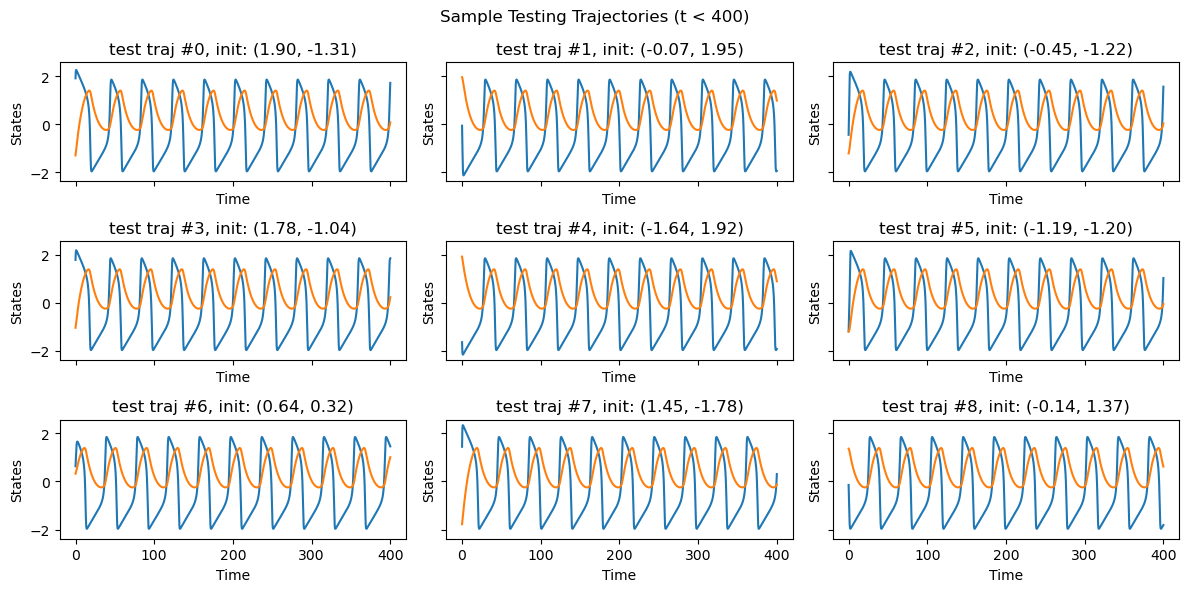

In [7]:
t = jnp.arange(0.0, T_final_test, dt)
fig, axes = plt.subplots(3, 3, figsize=(12, 6), sharex=True, sharey=True)
axe = axes.flatten()
for i in range(len(axe)):
    axe[i].plot(t, np.array(trajectories_test)[i,:, 0], label='x')
    axe[i].plot(t, np.array(trajectories_test[i,:, 1]), label='y')
    axe[i].set_xlabel('Time')
    axe[i].set_ylabel('States')
    axe[i].set_title(f'test traj #{i}, init: ({initial_states_test[i][0]:.2f}, {initial_states_test[i][1]:.2f})')
plt.suptitle("Sample Testing Trajectories (t < 400)")
plt.tight_layout()
plt.savefig("testing_traj.png", dpi = 300)
plt.show()


## rollout loss nn

### training

In [8]:
SEED = 777

INPUT_DIM  = 2
WIDTH      = 10
DEPTH      = 4
ACTIVATION = 'gelu'
# sine, cosine, relu, tanh, gelu, swish

HYPER_MODEL = {"input_dim": INPUT_DIM, 
               "output_dim": INPUT_DIM, 
               "width": WIDTH,
               "depth": DEPTH-1, 
               "act_func": ACTIVATION}


key = jr.PRNGKey(SEED)
key, subkey_model, = jr.split(key, num=2)
model = create_FNN(key=subkey_model, **HYPER_MODEL)

In [9]:
LEARNING_RATE = 1e-4
OPTIMIZER_NAME = 'radam'
# adabelief, adadelta, adan, adafactor, adagrad, adam, adamw,
# adamax, adamaxw, amsgrad, lion, nadam, nadamw, novograd, radam,
# rmsprop, sgd, sm3, yogi, polyak_sgd
MAXITER = 100_000
PRINT_EVERY = 1_00

LR_SCHEDULER = 'constant' # exponential or constant
LR_DECAY = 0.90
LR_STEP  = 1000

LBFGS_USE = 'off'
LBFGS_MAXITER = 1_000
LBFGS_PRINT_EVERY = 1_00
if LBFGS_USE != 'on':
    LBFGS_MAXITER = 0
    LBFGS_PRINT_EVERY = 0

HYPER_OPTIM = {"MAXITER": MAXITER, 
               "NAME": OPTIMIZER_NAME, 
               "LEARNING_RATE_SCHEDULER": LR_SCHEDULER, 
               "LEARNING_RATE_INITIAL": LEARNING_RATE, 
               "LEARNING_RATE_DECAY": LR_DECAY, 
               "LEARNING_RATE_STEP": LR_STEP, 
               "PRINT_EVERY": PRINT_EVERY,
               "LBFGS": {"USE": LBFGS_USE, "MAXITER": LBFGS_MAXITER, "PRINT_EVERY": LBFGS_PRINT_EVERY}
               }

In [10]:
def loss_fn(model): # rel l2 error
    residual = vmap(lambda x: rollout_fn(model, NUM_STEPS, dt, include_init=False)(x))(trajectories[:, 0, :]) - trajectories[:, 1:, :]
    return jnp.sqrt(jnp.sum(residual**2) / jnp.sum(trajectories[:, 1:, :] ** 2))

In [11]:
%%time
model, log_loss, log_minloss = training_MODEL(model, loss_fn, HYPER_OPTIM)

Selected Optimizer is [ radam ], Initial Learning Rate is 1.00e-04
You are using [ constant ] learning rate
-------------------------TRAINING STARTS-------------------------
-----------------------------------------------------------------
Epoch    0: loss = 8.6642e-02, minloss = 8.6642e-02, Time: 0.74s
Epoch  100: loss = 8.6479e-02, minloss = 8.6479e-02, Time: 0.20s
Epoch  200: loss = 8.6169e-02, minloss = 8.6169e-02, Time: 0.18s
Epoch  300: loss = 8.5769e-02, minloss = 8.5769e-02, Time: 0.18s
Epoch  400: loss = 8.5287e-02, minloss = 8.5287e-02, Time: 0.18s
Epoch  500: loss = 8.4709e-02, minloss = 8.4709e-02, Time: 0.19s
Epoch  600: loss = 8.4012e-02, minloss = 8.4012e-02, Time: 0.19s
Epoch  700: loss = 8.3156e-02, minloss = 8.3156e-02, Time: 0.21s
Epoch  800: loss = 8.2085e-02, minloss = 8.2085e-02, Time: 0.19s
Epoch  900: loss = 8.0711e-02, minloss = 8.0711e-02, Time: 0.19s
Epoch 1000: loss = 7.8917e-02, minloss = 7.8917e-02, Time: 0.19s
Epoch 1100: loss = 7.6563e-02, minloss = 7.65

### eval

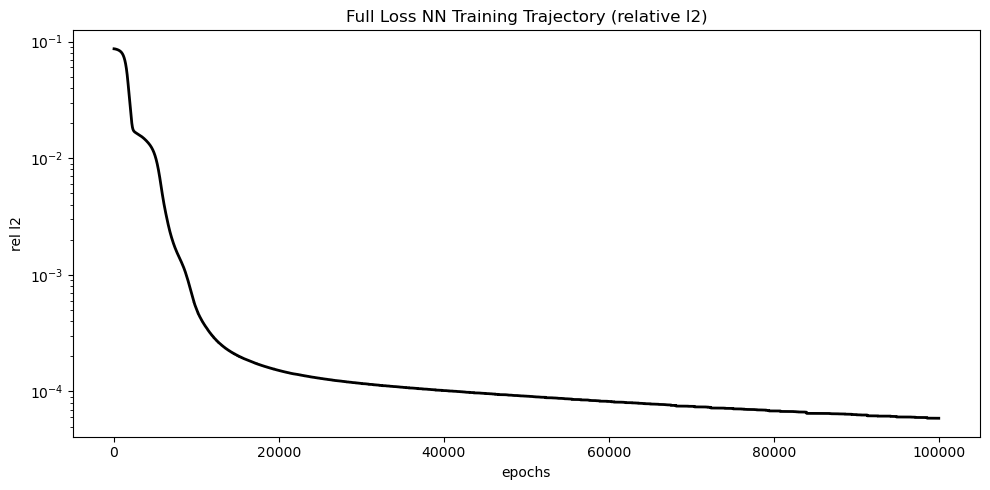

In [12]:
plt.figure(figsize = (10,5))
plt.plot(log_minloss, color = 'black', linewidth = 2)
plt.yscale('log')
plt.xlabel('epochs')
plt.ylabel('rel l2')
plt.title("Full Loss NN Training Trajectory (relative l2)")
plt.tight_layout()
plt.savefig('full_step_training_traj.png', dpi = 300)
plt.show()

(300, 40000, 2)
(40000,)


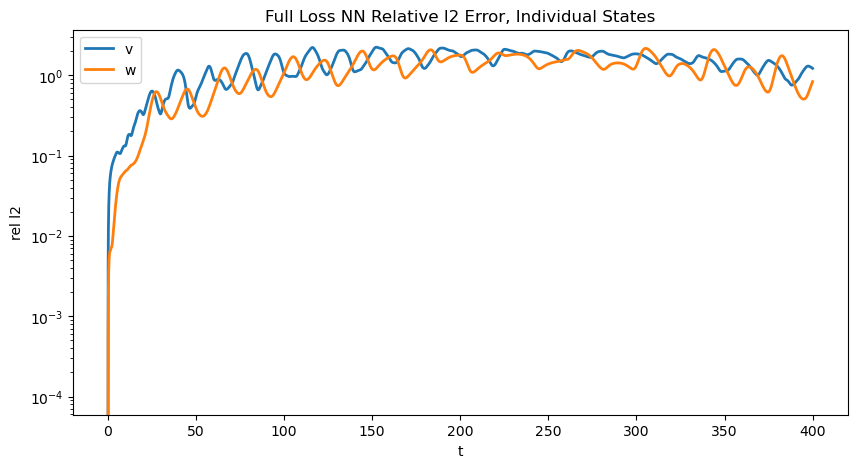

In [13]:
# all trained model predictions
pred = vmap(lambda x: rollout_fn(model, NUM_STEPS_TEST, dt, include_init=True)(x))(trajectories_test[:, 0, :])
print(pred.shape)

rel_l2_v = jnp.sqrt(jnp.sum((pred[:,:,0] - trajectories_test[:,:,0])**2, axis = 0) / jnp.sum((trajectories_test[:,:,0])**2, axis = 0))
print(rel_l2_v.shape)

rel_l2_w = jnp.sqrt(jnp.sum((pred[:,:,1] - trajectories_test[:,:,1])**2, axis = 0) / jnp.sum((trajectories_test[:,:,1])**2, axis = 0))

plt.figure(figsize = (10,5))
plt.plot(jnp.arange(0, T_final_test, dt), rel_l2_v, label = 'v', linewidth = 2)
plt.plot(jnp.arange(0, T_final_test, dt), rel_l2_w, label = 'w', linewidth = 2)
plt.xlabel("t")
plt.ylabel("rel l2")
plt.yscale("log")
plt.legend()
plt.title("Full Loss NN Relative l2 Error, Individual States")
plt.savefig("full_step_rel_l2.png", dpi = 300)
plt.show()

In [14]:
# calculate overall rel l2
overall_rel_l2 = jnp.sqrt(jnp.sum(jnp.sum((pred - trajectories_test)**2, axis = 0), axis = 0) / jnp.sum(jnp.sum((trajectories_test)**2, axis = 0), axis = 0))
print(f"overall rel l2 loss for [v,w] is: {overall_rel_l2}")

overall rel l2 loss for [v,w] is: [1.4855785 1.1930857]


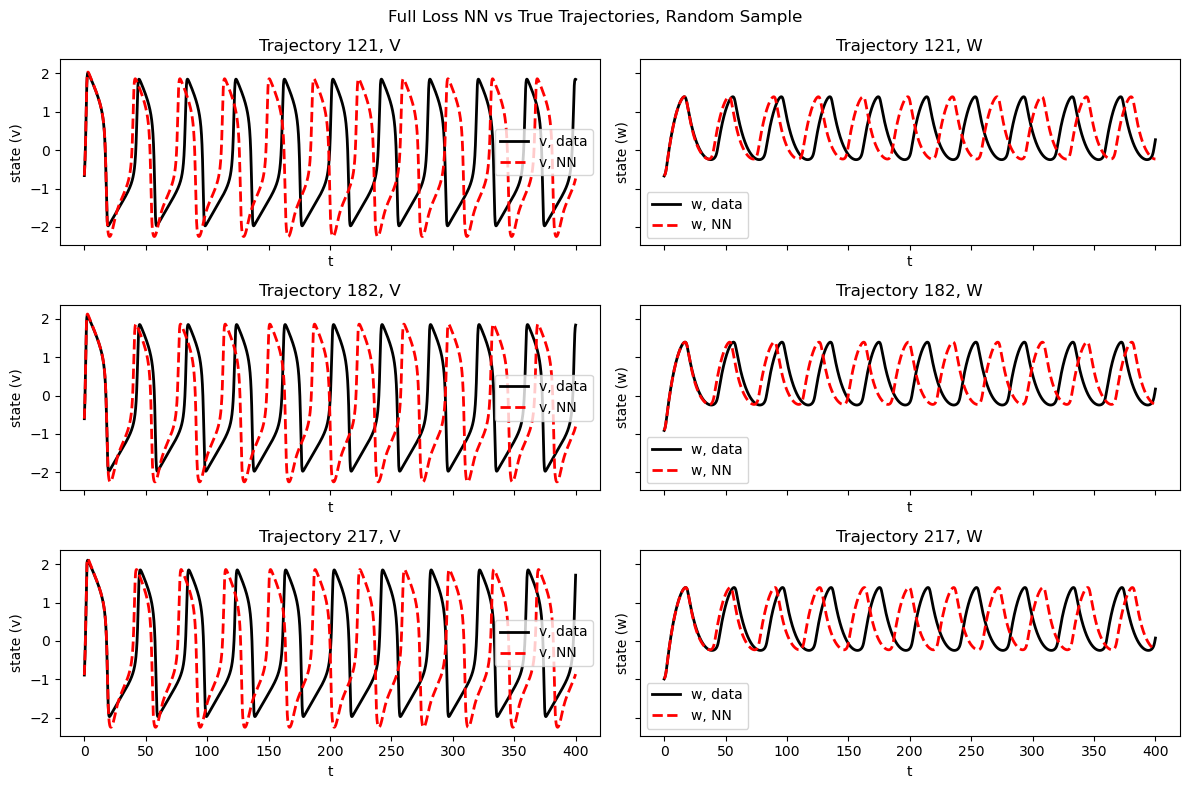

In [ ]:
rand_ints= jr.randint(key, (4,), 0, trajectories_test.shape[0])
rand_ints

t = jnp.arange(0.0, T_final_test, dt)
fig, axes = plt.subplots(3, 2, figsize=(12, 8), sharex = True, sharey = True)
axe = axes.flatten()

axe[0].set_title(f"Trajectory {rand_ints[0]}, V")
axe[0].plot(t, trajectories_test[rand_ints[0], :, 0], linewidth = 2, color = 'black', label = "v, data")
axe[0].plot(t, pred[rand_ints[0], :, 0], linewidth = 2, color = 'red', linestyle = '--', label = "v, NN")
axe[0].set_xlabel("t")
axe[0].set_ylabel("state (v)")
axe[0].legend()


axe[1].set_title(f"Trajectory {rand_ints[0]}, W")
axe[1].plot(t, trajectories_test[rand_ints[0], :, 1],  linewidth = 2, color = 'black', label = "w, data")
axe[1].plot(t, pred[rand_ints[0], :, 1],  linewidth = 2, color = 'red', linestyle = '--',  label = "w, NN")
axe[1].set_xlabel("t")
axe[1].set_ylabel("state (w)")
axe[1].legend()


axe[2].set_title(f"Trajectory {rand_ints[1]}, V")
axe[2].plot(t, trajectories_test[rand_ints[1], :, 0],  linewidth = 2, color = 'black', label = "v, data")
axe[2].plot(t, pred[rand_ints[1], :, 0],  linewidth = 2,color = 'red', linestyle = '--',  label = "v, NN")
axe[2].set_xlabel("t")
axe[2].set_ylabel("state (v)")
axe[2].legend()


axe[3].set_title(f"Trajectory {rand_ints[1]}, W")
axe[3].plot(t, trajectories_test[rand_ints[1], :, 1],  linewidth = 2,color = 'black',  label = "w, data")
axe[3].plot(t, pred[rand_ints[1], :, 1],  linewidth = 2, color = 'red', linestyle = '--',  label = "w, NN")
axe[3].set_xlabel("t")
axe[3].set_ylabel("state (w)")
axe[3].legend()


axe[4].set_title(f"Trajectory {rand_ints[2]}, V")
axe[4].plot(t, trajectories_test[rand_ints[2], :, 0], linewidth = 2, color = 'black', label = "v, data")
axe[4].plot(t, pred[rand_ints[2], :, 0],  linewidth = 2, color = 'red', linestyle = '--',  label = "v, NN")
axe[4].set_xlabel("t")
axe[4].set_ylabel("state (v)")
axe[4].legend()


axe[5].set_title(f"Trajectory {rand_ints[2]}, W")
axe[5].plot(t, trajectories_test[rand_ints[2], :, 1],  linewidth = 2,color = 'black', label = "w, data")
axe[5].plot(t, pred[rand_ints[2], :, 1], linewidth = 2, color = 'red', linestyle = '--',  label = "w, NN")
axe[5].set_xlabel("t")
axe[5].set_ylabel("state (w)")
axe[5].legend()


plt.suptitle("Full Loss NN vs True Trajectories, Random Sample")
plt.tight_layout()
plt.savefig("full_step_sample.png", dpi = 300)


## one-step nn

In [16]:
x_at_now  = trajectories[:, :-1, :].reshape(-1, 2)
x_at_next = trajectories[:, 1:, :].reshape(-1, 2)

### training

In [18]:
%%time 
os_model = create_FNN(key=subkey_model, **HYPER_MODEL) # use same config as full loss model

def os_loss_fn(model_in):
    residual = vmap(lambda x: rollout_fn(model_in, 1, dt, include_init=False)(x))(x_at_now)[:,0,:] - x_at_next
    return jnp.sqrt(jnp.sum(residual**2)/jnp.sum(x_at_next **2))

os_model, os_log_loss, os_log_minloss = training_MODEL(os_model, os_loss_fn, HYPER_OPTIM)


Selected Optimizer is [ radam ], Initial Learning Rate is 1.00e-04
You are using [ constant ] learning rate
-------------------------TRAINING STARTS-------------------------
-----------------------------------------------------------------
Epoch    0: loss = 7.1786e-03, minloss = 7.1786e-03, Time: 0.50s
Epoch  100: loss = 7.1653e-03, minloss = 7.1653e-03, Time: 0.12s
Epoch  200: loss = 7.1399e-03, minloss = 7.1399e-03, Time: 0.12s
Epoch  300: loss = 7.1068e-03, minloss = 7.1068e-03, Time: 0.13s
Epoch  400: loss = 7.0665e-03, minloss = 7.0665e-03, Time: 0.13s
Epoch  500: loss = 7.0180e-03, minloss = 7.0180e-03, Time: 0.13s
Epoch  600: loss = 6.9592e-03, minloss = 6.9592e-03, Time: 0.13s
Epoch  700: loss = 6.8867e-03, minloss = 6.8867e-03, Time: 0.13s
Epoch  800: loss = 6.7947e-03, minloss = 6.7947e-03, Time: 0.13s
Epoch  900: loss = 6.6748e-03, minloss = 6.6748e-03, Time: 0.13s
Epoch 1000: loss = 6.5155e-03, minloss = 6.5155e-03, Time: 0.13s
Epoch 1100: loss = 6.3016e-03, minloss = 6.30

### eval

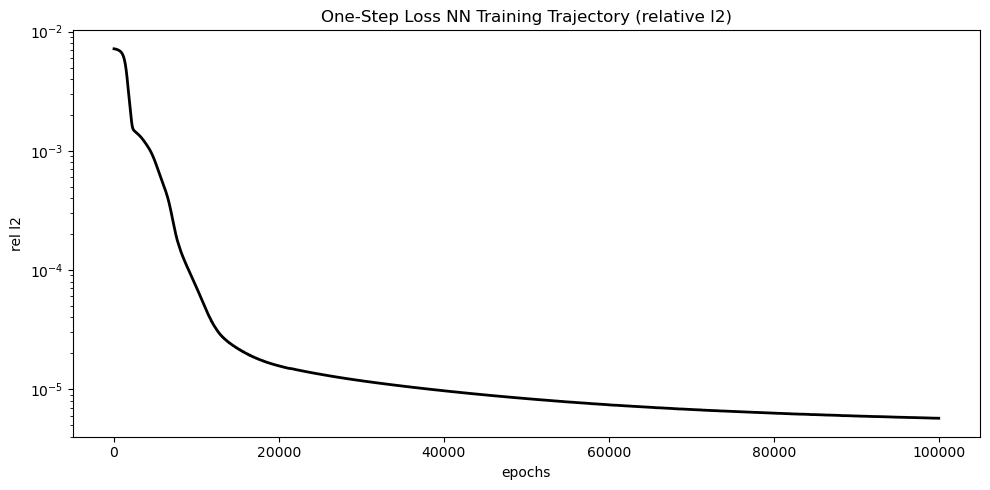

In [19]:
plt.figure(figsize = (10,5))
plt.plot(os_log_minloss, color = 'black', linewidth = 2)
plt.yscale('log')
plt.xlabel('epochs')
plt.ylabel('rel l2')
plt.title("One-Step Loss NN Training Trajectory (relative l2)")
plt.tight_layout()
plt.savefig('one_step_training_traj.png', dpi = 300)
plt.show()

(300, 40000, 2)
(40000,)


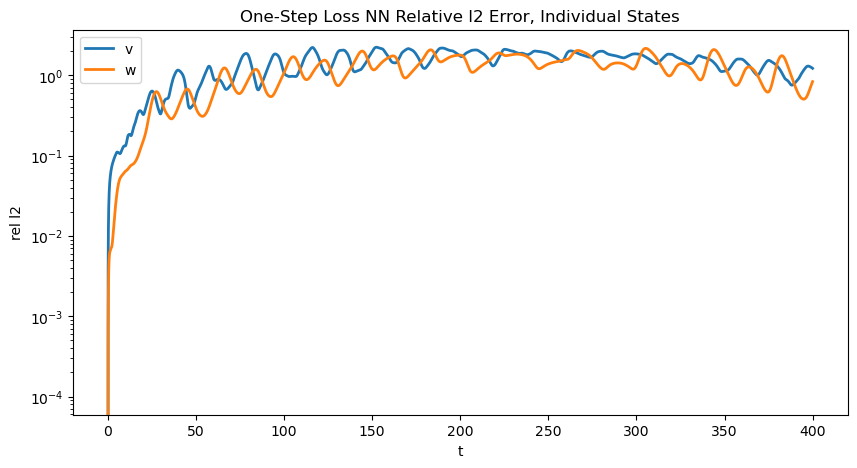

In [20]:
# all trained model predictions
os_pred = vmap(lambda x: rollout_fn(os_model, NUM_STEPS_TEST, dt, include_init=True)(x))(trajectories_test[:, 0, :])
print(os_pred.shape)

os_rel_l2_v = jnp.sqrt(jnp.sum((os_pred[:,:,0] - trajectories_test[:,:,0])**2, axis = 0) / jnp.sum((trajectories_test[:,:,0])**2, axis = 0))
print(os_rel_l2_v.shape)

os_rel_l2_w = jnp.sqrt(jnp.sum((os_pred[:,:,1] - trajectories_test[:,:,1])**2, axis = 0) / jnp.sum((trajectories_test[:,:,1])**2, axis = 0))

plt.figure(figsize = (10,5))
plt.plot(jnp.arange(0, T_final_test, dt), rel_l2_v, label = 'v', linewidth = 2)
plt.plot(jnp.arange(0, T_final_test, dt), rel_l2_w, label = 'w', linewidth = 2)
plt.xlabel("t")
plt.ylabel("rel l2")
plt.yscale("log")
plt.legend()
plt.title("One-Step Loss NN Relative l2 Error, Individual States")
plt.savefig("one_step_rel_l2.png", dpi = 300)
plt.show()

In [21]:
# calculate overall rel l2
os_overall_rel_l2 = jnp.sqrt(jnp.sum(jnp.sum((os_pred - trajectories_test)**2, axis = 0), axis = 0) / jnp.sum(jnp.sum((trajectories_test)**2, axis = 0), axis = 0))
print(f"overall rel l2 loss for [v,w] is: {os_overall_rel_l2}")

overall rel l2 loss for [v,w] is: [0.09821305 0.0626443 ]


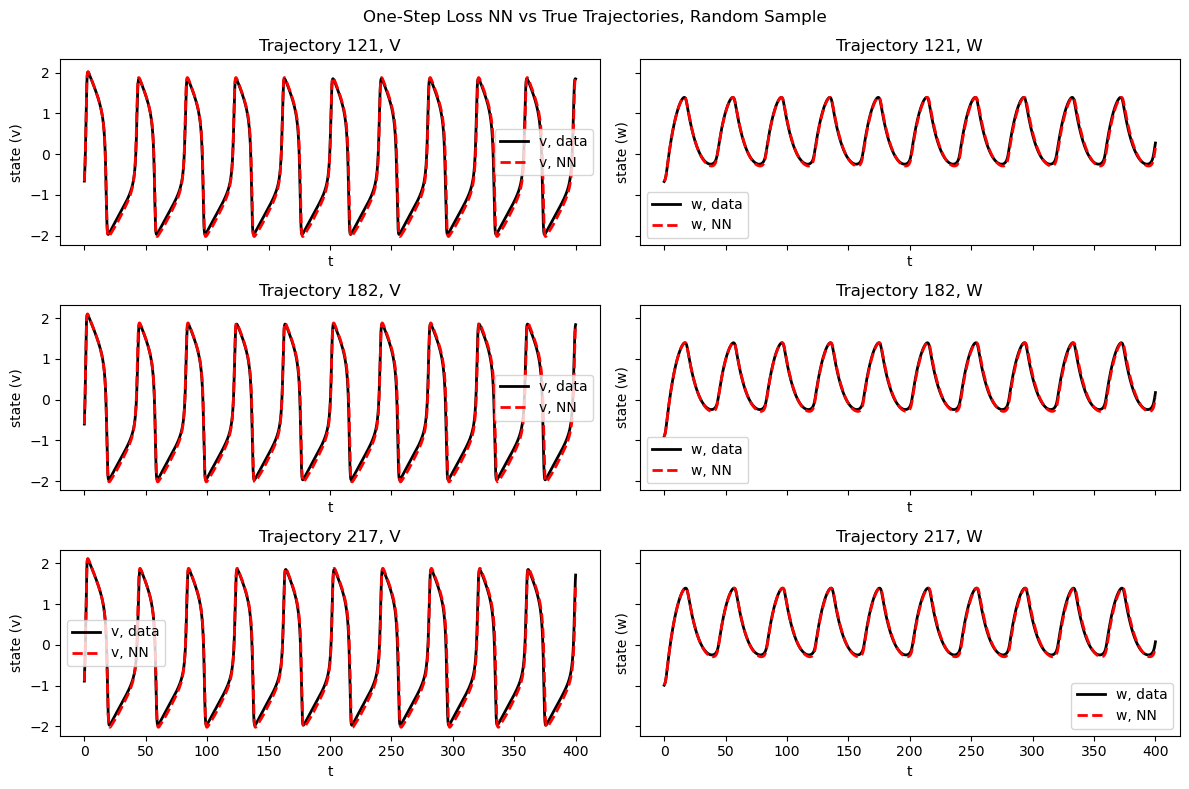

In [ ]:
rand_ints= jr.randint(key, (4,), 0, trajectories_test.shape[0])
rand_ints

t = jnp.arange(0.0, T_final_test, dt)
fig, axes = plt.subplots(3, 2, figsize=(12, 8), sharex = True, sharey = True)
axe = axes.flatten()

axe[0].set_title(f"Trajectory {rand_ints[0]}, V")
axe[0].plot(t, trajectories_test[rand_ints[0], :, 0], linewidth = 2, color = 'black', label = "v, data")
axe[0].plot(t, os_pred[rand_ints[0], :, 0], linewidth = 2, color = 'red', linestyle = '--', label = "v, NN")
axe[0].set_xlabel("t")
axe[0].set_ylabel("state (v)")
axe[0].legend()


axe[1].set_title(f"Trajectory {rand_ints[0]}, W")
axe[1].plot(t, trajectories_test[rand_ints[0], :, 1],  linewidth = 2, color = 'black', label = "w, data")
axe[1].plot(t, os_pred[rand_ints[0], :, 1],  linewidth = 2, color = 'red', linestyle = '--',  label = "w, NN")
axe[1].set_xlabel("t")
axe[1].set_ylabel("state (w)")
axe[1].legend()


axe[2].set_title(f"Trajectory {rand_ints[1]}, V")
axe[2].plot(t, trajectories_test[rand_ints[1], :, 0],  linewidth = 2, color = 'black', label = "v, data")
axe[2].plot(t, os_pred[rand_ints[1], :, 0],  linewidth = 2,color = 'red', linestyle = '--',  label = "v, NN")
axe[2].set_xlabel("t")
axe[2].set_ylabel("state (v)")
axe[2].legend()


axe[3].set_title(f"Trajectory {rand_ints[1]}, W")
axe[3].plot(t, trajectories_test[rand_ints[1], :, 1],  linewidth = 2,color = 'black',  label = "w, data")
axe[3].plot(t, os_pred[rand_ints[1], :, 1],  linewidth = 2, color = 'red', linestyle = '--',  label = "w, NN")
axe[3].set_xlabel("t")
axe[3].set_ylabel("state (w)")
axe[3].legend()


axe[4].set_title(f"Trajectory {rand_ints[2]}, V")
axe[4].plot(t, trajectories_test[rand_ints[2], :, 0], linewidth = 2, color = 'black', label = "v, data")
axe[4].plot(t, os_pred[rand_ints[2], :, 0],  linewidth = 2, color = 'red', linestyle = '--',  label = "v, NN")
axe[4].set_xlabel("t")
axe[4].set_ylabel("state (v)")
axe[4].legend()


axe[5].set_title(f"Trajectory {rand_ints[2]}, W")
axe[5].plot(t, trajectories_test[rand_ints[2], :, 1],  linewidth = 2,color = 'black', label = "w, data")
axe[5].plot(t, os_pred[rand_ints[2], :, 1], linewidth = 2, color = 'red', linestyle = '--',  label = "w, NN")
axe[5].set_xlabel("t")
axe[5].set_ylabel("state (w)")
axe[5].legend()


plt.suptitle("One-Step Loss NN vs True Trajectories, Random Sample")
plt.tight_layout()
plt.savefig("one_step_sample.png", dpi = 300)
plt.show()
